# **Baseline Model Implementation**

#### Importing libraries

In [1]:
#importing required libraries for data analysis
import pandas as pd
import numpy as np

#Visuals and Time libraries
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')

#Import Data balancing libraries
import imblearn
from imblearn.over_sampling import SMOTE

# Import models from sklearn
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Import evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:
# Read the training & test datasets from Part1-Preprocessing part

x_train=pd.read_csv('x_train.csv')
x_test=pd.read_csv('x_test.csv')

y_train=pd.read_csv('y_train.csv')
y_test=pd.read_csv('y_test.csv')

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(19141, 19) (8984, 19) (19141, 1) (8984, 1)


### Data Balancing


In supervised learning, a common strategy to overcome the class imbalance problem is to resample the original training dataset to decrease the overall level of class imbalance. Resampling is done either by oversampling the minority (positive) class and/or under-sampling the majority (negative) class until the classes are approximately equally represented.

All resampling operations are applied to only training datasets. If upsampling is done before splitting the dataset into a train and validation set, then it could end up with the same observation in both datasets. As a result, a machine learning model will be able to perfectly predict the value for those observations when predicting on the validation set, hence inflating the accuracy and recall.

A. Under Sampling:

    1. Random undersampling --> rus =  RandomUnderSampler()
    2. Near Miss --> nm = NearMiss()

B. Over Sampling:
    
    3. Random oversampling  --> ros =  RandomOverSampler()
    4. SMOTE (Synthetic Minority Over-Sampling Technique)
        sm = SMOTE()
        x_train_smote, y_train_smote = sm.fit_sample(x_train, y_train)
        x_train_smote.shape,y_train_smote.shape
    5. ADASYN (Adaptive Synthetic Sampling) --> adasyn =  ADASYN()

C. Hybrid Sampling:

    6. SMOTE+ENN --> smtenn =  SMOTEENN()
    7. SMOTE+Tomek link --> smtom =  SMOTETomek()

In [3]:
#importing SMOTE to handle class imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x_train, y_train)

print('Original unbalanced dataset shape', len(y_train))
print('Resampled balanced dataset shape', len(y_smote))

Original unbalanced dataset shape 19141
Resampled balanced dataset shape 29886


In [4]:
# Saving final balanced files in csv format for future reference (for Part 3)

pd.DataFrame(x_smote).to_csv("x_smote.csv", index=None)
pd.DataFrame(y_smote).to_csv("y_smote.csv", index=None)

### 1. **Logistic Regression Model**

In [5]:
# Importing the Logistic Regression Model
start = time.time()
logmodel = LogisticRegression(random_state=1)
logmodel.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = logmodel.predict(x_test)
y_train_pred = logmodel.predict(x_smote)

In [6]:
#getting all scores for Logistic Regression
log_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
log_acc = round(accuracy_score(y_pred,y_test), 3)
log_prec = round(precision_score(y_pred,y_test), 3)
log_rec = round(recall_score(y_pred,y_test), 3)
log_f1 = round(f1_score(y_pred,y_test), 3)
log_roc = round(roc_auc_score(y_pred,y_test), 3)
log_time=stop-start

results = pd.DataFrame([['Logistic Regression', log_acctr, log_acc, log_prec, log_rec, log_f1, log_roc, log_time]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s)
0,Logistic Regression,0.58,0.614,0.479,0.283,0.356,0.548,0.123402


In [7]:
# Confusion Matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.65      0.72      6985
           1       0.28      0.48      0.36      1999

    accuracy                           0.61      8984
   macro avg       0.55      0.57      0.54      8984
weighted avg       0.70      0.61      0.64      8984

[[4557 2428]
 [1041  958]]


In [8]:
# # Identifying Important features used for Training
# feature_imp = pd.Series(logmodel.coef_, index=x_smote.columns).sort_values(ascending=False).head(15)
# sns.barplot(x=feature_imp, y=feature_imp.index)
# plt.xlabel('Feature Importance Score')
# plt.title("Visualizing significant features from Logistic Regression")


# ft_imp = pd.DataFrame(data={
#     'Attribute': x_smote.columns,
#     'Importance': logmodel.coef_[0]})
# ft_imp = ft_imp.sort_values(by='Importance', ascending=False)
# plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
# plt.title('Feature importances obtained from coefficients', size=10)
# plt.xticks(rotation='vertical')
# plt.show()

### 2. **Support Vector Machines**

In [9]:
# # Importing the Naive Bayes Model
# start = time.time()
# svm = SVC(kernel = 'rbf', random_state = 0)
# svm.fit(x_smote,y_smote)
# stop = time.time()

# # predicting the y test observations
# y_pred = svm.predict(x_test)
# y_train_pred = svm.predict(x_smote)

In [10]:
# #getting all scores for Naive Bayes Model
# svm_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
# svm_acc = round(accuracy_score(y_pred,y_test), 3)
# svm_prec = round(precision_score(y_pred,y_test), 3)
# svm_rec = round(recall_score(y_pred,y_test), 3)
# svm_f1 = round(f1_score(y_pred,y_test), 3)
# svm_roc = round(roc_auc_score(y_pred,y_test), 3)
# svm_time=stop-start

# results = pd.DataFrame([['Support Vector Machines', svm_acctr, svm_acc, svm_prec, svm_rec, svm_f1, svm_roc, svm_time]],
#              columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
# results

In [11]:
# # Confusion Matrix
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

### 2. **Naive Bayes**

In [12]:
# Importing the Naive Bayes Model
start = time.time()
nb = GaussianNB()
nb.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = nb.predict(x_test)
y_train_pred = nb.predict(x_smote)

In [13]:
#getting all scores for Naive Bayes Model
nb_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
nb_acc = round(accuracy_score(y_pred,y_test), 3)
nb_prec = round(precision_score(y_pred,y_test), 3)
nb_rec = round(recall_score(y_pred,y_test), 3)
nb_f1 = round(f1_score(y_pred,y_test), 3)
nb_roc = round(roc_auc_score(y_pred,y_test), 3)
nb_time=stop-start

results = pd.DataFrame([['Naive Bayes', nb_acctr, nb_acc, nb_prec, nb_rec, nb_f1, nb_roc, nb_time]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s)
0,Naive Bayes,0.603,0.557,0.681,0.289,0.406,0.57,0.022859


In [14]:
# Confusion Matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.52      0.65      6985
           1       0.29      0.68      0.41      1999

    accuracy                           0.56      8984
   macro avg       0.57      0.60      0.53      8984
weighted avg       0.73      0.56      0.59      8984

[[3640 3345]
 [ 638 1361]]


### 3. **KNN classifier algorithm**

In [15]:
# Importing the KNN classifier
start = time.time()
knn = KNeighborsClassifier()
knn.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = knn.predict(x_test)
y_train_pred = knn.predict(x_smote)

In [16]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [17]:
#getting all scores for KNN classifier
knn_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
knn_acc = round(accuracy_score(y_pred,y_test), 3)
knn_prec = round(precision_score(y_pred,y_test), 3)
knn_rec = round(recall_score(y_pred,y_test), 3)
knn_f1 = round(f1_score(y_pred,y_test), 3)
knn_roc = round(roc_auc_score(y_pred,y_test), 3)
knn_time=stop-start

results = pd.DataFrame([['KNN classifier', knn_acctr, knn_acc, knn_prec, knn_rec, knn_f1, knn_roc, knn_time]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s)
0,KNN classifier,0.843,0.629,0.5,0.3,0.375,0.561,0.010412


In [18]:
# Confusion Matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.67      0.74      6985
           1       0.30      0.50      0.37      1999

    accuracy                           0.63      8984
   macro avg       0.56      0.58      0.56      8984
weighted avg       0.71      0.63      0.66      8984

[[4649 2336]
 [ 999 1000]]


### 4. **Decision Tree Classification**

In [19]:
#fitting data into Decision Tree Classifier
start = time.time()
dtc = DecisionTreeClassifier()
dtc.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = dtc.predict(x_test)
y_train_pred = dtc.predict(x_smote)

In [20]:
#getting all scores for Decision Tree Classifier
dtc_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
dtc_acc = round(accuracy_score(y_pred,y_test), 3)
dtc_prec = round(precision_score(y_pred,y_test), 3)
dtc_rec = round(recall_score(y_pred,y_test), 3)
dtc_f1 = round(f1_score(y_pred,y_test), 3)
dtc_roc = round(roc_auc_score(y_pred,y_test), 3)
dtc_time=stop-start

results = pd.DataFrame([['Decision Trees', dtc_acctr, dtc_acc, dtc_prec, dtc_rec, dtc_f1, dtc_roc, dtc_time]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s)
0,Decision Trees,0.994,0.716,0.407,0.373,0.389,0.6,0.641122


In [21]:
# Confusion Matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      6985
           1       0.37      0.41      0.39      1999

    accuracy                           0.72      8984
   macro avg       0.60      0.61      0.60      8984
weighted avg       0.73      0.72      0.72      8984

[[5621 1364]
 [1186  813]]


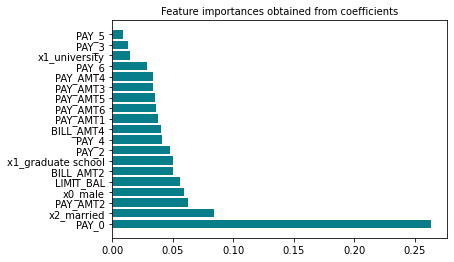

In [22]:
importances = pd.DataFrame(data={
    'Attribute': x_smote.columns,
    'Importance': dtc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.barh(y=importances['Attribute'], width=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=10)
plt.show()

### 5. **Random Forest Classification**

In [23]:
#fitting data into Random Forest Classifier
start = time.time()
rfc = RandomForestClassifier()
rfc.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = rfc.predict(x_test)
y_train_pred = rfc.predict(x_smote)

In [24]:
#getting all scores for Random Forest Classifier
rfc_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
rfc_acc = round(accuracy_score(y_pred,y_test), 3)
rfc_prec = round(precision_score(y_pred,y_test), 3)
rfc_rec = round(recall_score(y_pred,y_test), 3)
rfc_f1 = round(f1_score(y_pred,y_test), 3)
rfc_roc = round(roc_auc_score(y_pred,y_test), 3)
rfc_time=stop-start

results = pd.DataFrame([['Random Forest', rfc_acctr, rfc_acc, rfc_prec, rfc_rec, rfc_f1, rfc_roc, rfc_time]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s)
0,Random Forest,0.994,0.8,0.385,0.574,0.461,0.706,11.154117


In [25]:
# Confusion Matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      6985
           1       0.57      0.38      0.46      1999

    accuracy                           0.80      8984
   macro avg       0.71      0.65      0.67      8984
weighted avg       0.78      0.80      0.78      8984

[[6414  571]
 [1230  769]]


### 6.  **Gradient Boosting**

In [26]:
#fitting data into Gradient Boosting Classifier
start = time.time()
gbc = GradientBoostingClassifier()
gbc.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = gbc.predict(x_test)
y_train_pred = gbc.predict(x_smote)

In [27]:
#getting all scores for Logistic Regression
gbc_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
gbc_acc = round(accuracy_score(y_pred,y_test), 3)
gbc_prec = round(precision_score(y_pred,y_test), 3)
gbc_rec = round(recall_score(y_pred,y_test), 3)
gbc_f1 = round(f1_score(y_pred,y_test), 3)
gbc_roc = round(roc_auc_score(y_pred,y_test), 3)
gbc_time=stop-start

results = pd.DataFrame([['Gradient Boosting', gbc_acctr, gbc_acc, gbc_prec, gbc_rec, gbc_f1, gbc_roc, gbc_time]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s)
0,Gradient Boosting,0.872,0.811,0.398,0.618,0.484,0.731,17.474271


In [28]:
# Confusion Matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      6985
           1       0.62      0.40      0.48      1999

    accuracy                           0.81      8984
   macro avg       0.73      0.66      0.68      8984
weighted avg       0.79      0.81      0.80      8984

[[6494  491]
 [1203  796]]


### 7. **XG Boosting**

In [29]:
#fitting data into XG Boosting Classifier
start = time.time()
xgb = XGBClassifier()
xgb.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = xgb.predict(x_test)
y_train_pred = xgb.predict(x_smote)

In [30]:
#getting all scores for XG Boosting Classifier
xgb_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
xgb_acc = round(accuracy_score(y_pred,y_test), 3)
xgb_prec = round(precision_score(y_pred,y_test), 3)
xgb_rec = round(recall_score(y_pred,y_test), 3)
xgb_f1 = round(f1_score(y_pred,y_test), 3)
xgb_roc = round(roc_auc_score(y_pred,y_test), 3)
xgb_time=stop-start

results = pd.DataFrame([['XG Boosting', xgb_acctr, xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_roc, xgb_time]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s)
0,XG Boosting,0.925,0.802,0.378,0.586,0.459,0.712,3.862305


In [31]:
# Confusion Matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      6985
           1       0.59      0.38      0.46      1999

    accuracy                           0.80      8984
   macro avg       0.71      0.65      0.67      8984
weighted avg       0.78      0.80      0.79      8984

[[6452  533]
 [1244  755]]


### 8. **ADA Boosting**

In [32]:
#fitting data into Ada Boosting Classifier
start = time.time()
ada = AdaBoostClassifier()
ada.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = ada.predict(x_test)
y_train_pred = ada.predict(x_smote)

In [33]:
#getting all scores for Ada Boosting Classifier
ada_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
ada_acc = round(accuracy_score(y_pred,y_test), 3)
ada_prec = round(precision_score(y_pred,y_test), 3)
ada_rec = round(recall_score(y_pred,y_test), 3)
ada_f1 = round(f1_score(y_pred,y_test), 3)
ada_roc = round(roc_auc_score(y_pred,y_test), 3)
ada_time=stop-start

results = pd.DataFrame([['ADA Boosting', ada_acctr, ada_acc, ada_prec, ada_rec, ada_f1, ada_roc, ada_time]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s)
0,ADA Boosting,0.856,0.8,0.397,0.573,0.469,0.707,4.455209


In [34]:
# Confusion Matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      6985
           1       0.57      0.40      0.47      1999

    accuracy                           0.80      8984
   macro avg       0.71      0.66      0.67      8984
weighted avg       0.78      0.80      0.79      8984

[[6394  591]
 [1206  793]]


### 9. **Bagging Classifier**

In [35]:
#fitting data into Bagging Classifier
start = time.time()
bag = BaggingClassifier()
bag.fit(x_smote,y_smote)
stop = time.time()

# predicting the y test observations
y_pred = bag.predict(x_test)
y_train_pred = bag.predict(x_smote)

In [36]:
#getting all scores for Bagging Classifier
bag_acctr = round(accuracy_score(y_train_pred,y_smote), 3)
bag_acc = round(accuracy_score(y_pred,y_test), 3)
bag_prec = round(precision_score(y_pred,y_test), 3)
bag_rec = round(recall_score(y_pred,y_test), 3)
bag_f1 = round(f1_score(y_pred,y_test), 3)
bag_roc = round(roc_auc_score(y_pred,y_test), 3)
bag_time=stop-start

results = pd.DataFrame([['Bagging Classifier', bag_acctr, bag_acc, bag_prec, bag_rec, bag_f1, bag_roc, bag_time]],
            columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC', 'Training Time(s)'])
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC,Training Time(s)
0,Bagging Classifier,0.984,0.79,0.346,0.543,0.423,0.687,4.022153


In [37]:
# Confusion Matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      6985
           1       0.54      0.35      0.42      1999

    accuracy                           0.79      8984
   macro avg       0.69      0.63      0.65      8984
weighted avg       0.77      0.79      0.77      8984

[[6402  583]
 [1307  692]]


### **Baseline Model Comparision**

In [38]:
# all_classifiers = ['Logistic Regression', 'Support Vector Machines', 'KNN Classifier', 'Naive Bayes', 'Decision Tree', 
#                    'Random Forest', 'Gradient Boosting', 'XG Boosting', 'Ada Boosting', 'Bagging algorithm']

# train_accuracy =  [log_acctr, svm_acctr, knn_acctr, nb_acctr, dtc_acctr, rfc_acctr, gbc_acctr, xgb_acctr, ada_acctr, bag_acctr]
# test_accuracy =   [log_acc, svm_acc, knn_acc, nb_acc, dtc_acc, rfc_acc, gbc_acc, xgb_acc, ada_acc, bag_acc]
# precision_score = [log_prec, svm_prec, knn_prec, nb_prec, dtc_prec, rfc_prec, gbc_prec, xgb_prec, ada_prec, bag_prec]
# recall_score =    [log_rec, svm_rec, knn_rec, nb_rec, dtc_rec, rfc_rec, gbc_rec, xgb_rec, ada_rec, bag_rec]
# f1_score =        [log_f1, svm_f1, knn_f1, nb_f1, dtc_f1, rfc_f1, gbc_f1, xgb_f1, ada_f1, bag_f1]
# roc_score =       [log_roc, svm_roc, knn_roc, nb_roc, dtc_roc, rfc_roc, gbc_roc, xgb_roc, ada_roc, bag_roc]
# training_time=[log_time, svm_time, knn_time, nb_time, dtc_time, rfc_time, gbc_time, xgb_time, ada_time, bag_time]

In [39]:
all_classifiers = ['Logistic Regression', 'KNN Classifier', 'Naive Bayes', 'Decision Tree', 
                   'Random Forest', 'Gradient Boosting', 'XG Boosting', 'Ada Boosting', 'Bagging algorithm']

train_accuracy =  [log_acctr, knn_acctr, nb_acctr, dtc_acctr, rfc_acctr, gbc_acctr, xgb_acctr, ada_acctr, bag_acctr]
test_accuracy =   [log_acc, knn_acc, nb_acc, dtc_acc, rfc_acc, gbc_acc, xgb_acc, ada_acc, bag_acc]
precision_score = [log_prec, knn_prec, nb_prec, dtc_prec, rfc_prec, gbc_prec, xgb_prec, ada_prec, bag_prec]
recall_score =    [log_rec, knn_rec, nb_rec, dtc_rec, rfc_rec, gbc_rec, xgb_rec, ada_rec, bag_rec]
f1_score =        [log_f1, knn_f1, nb_f1, dtc_f1, rfc_f1, gbc_f1, xgb_f1, ada_f1, bag_f1]
roc_score =       [log_roc, knn_roc, nb_roc, dtc_roc, rfc_roc, gbc_roc, xgb_roc, ada_roc, bag_roc]
training_time=[log_time, knn_time, nb_time, dtc_time, rfc_time, gbc_time, xgb_time, ada_time, bag_time]

In [40]:
compare_df = pd.DataFrame({'Classifier':all_classifiers, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 
                           'Precision': precision_score, 'Recall': recall_score, 'F1 Score': f1_score, 
                           'AUC': roc_score, 'Training Time':training_time})
compare_df

,Classifier,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC,Training Time
0,Logistic Regression,0.580,0.614,0.479,0.283,0.356,0.548,0.123402
1,KNN Classifier,0.843,0.629,0.500,0.300,0.375,0.561,0.010412
2,Naive Bayes,0.603,0.557,0.681,0.289,0.406,0.570,0.022859
3,Decision Tree,0.994,0.716,0.407,0.373,0.389,0.600,0.641122
4,Random Forest,0.994,0.800,0.385,0.574,0.461,0.706,11.154117
5,Gradient Boosting,0.872,0.811,0.398,0.618,0.484,0.731,17.474271
6,XG Boosting,0.925,0.802,0.378,0.586,0.459,0.712,3.862305
7,Ada Boosting,0.856,0.800,0.397,0.573,0.469,0.707,4.455209
8,Bagging algorithm,0.984,0.790,0.346,0.543,0.423,0.687,4.022153


#### Conclusion from Baseline models

1. From all baseline model, XG Boosting classifier shows better test accuracy and F1 score and AUC.
2. Ensemble models shows better performance compated to base models (except for Logistic regression model)
3. Train accuracy - There is huge difference between Train and Test Accuracy in tree based models which shows OverFitting

We can try in the next part, Cross validation and Hyperparameter tuning techniques to reduce chances of overfitting and also increases performance of model.